# **Used Car Price Prediction**

**Description** : Proses pembuatan model untuk prediksi harga mobil bekas

**Dataset** : https://www.kaggle.com/datasets/adityadesai13/used-car-dataset-ford-and-mercedes

**Model** : Random Forest, Gradient Boosting, XGBoost, KNN, dan LightGBM

# **Data Loading**

Pada bagian ini, kita akan mencoba membaca dataset secara langsung dari folder dataset "100,000 UK Used Car Dataset" yang sudah di download melalui Kaggle. Dataset yang digunakan adalah audi.csv, bmw.csv, cclass.csv, focus.csv, ford.csv, hyundi.csv, merc.csv, skoda.csv, toyota.csv, vauxhall.csv, vw.csv yang berisi dataset untuk proses pelatihan model.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
import os

In [ ]:
folder_path = "/kaggle/input/used-car-dataset-ford-and-mercedes"

csv_files = [file for file in os.listdir(folder_path)
             if file.endswith('.csv') and "unclean" not in file.lower()]

# Mapping untuk perbaikan nama brand
brand_corrections = {
    "hyundi": "hyundai",
    "merc": "mercedes",
    "cclass": "mercedes",
    "focus": "ford"
}

df_list = []
for file in csv_files:
    brand = file.split(".")[0].lower()

    brand = brand_corrections.get(brand, brand)

    df_temp = pd.read_csv(os.path.join(folder_path, file))
    df_temp = df_temp.rename(columns={"tax(£)": "tax"})
    df_temp["brand"] = brand

    df_list.append(df_temp)

df = pd.concat(df_list, ignore_index=True)

cols = ["brand"] + [col for col in df.columns if col != "brand"]
df = df[cols]

df.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,brand,model,year,price,transmission,mileage,fuelType,engineSize,tax,mpg
0,mercedes,C Class,2020,30495,Automatic,1200,Diesel,2.0,NaN,NaN
1,mercedes,C Class,2020,29989,Automatic,1000,Petrol,1.5,NaN,NaN
2,mercedes,C Class,2020,37899,Automatic,500,Diesel,2.0,NaN,NaN
3,mercedes,C Class,2019,30399,Automatic,5000,Diesel,2.0,NaN,NaN
4,mercedes,C Class,2019,29899,Automatic,4500,Diesel,2.0,NaN,NaN


# Exploratory Data Analysis (EDA)

Setelah mendapatkan dataset, proses selanjutnya adalah melakukan Exploratory Data analysis (EDA). EDA adalah proses analisis awal pada suatu dataset untuk memahami karakteristik, distribusi, pola, serta hubungan antar variabel sebelum dilakukan pemodelan. EDA bertujuan untuk menemukan missing values, outlier, distribusi data, serta korelasi antar fitur, sehingga dapat menentukan langkah preprocessing yang tepat.

Dalam EDA, teknik yang sering digunakan meliputi statistik deskriptif (mean, median, standar deviasi), visualisasi data (histogram, boxplot, scatter plot), serta analisis korelasi antar variabel. Dengan melakukan EDA, kita dapat mengidentifikasi potensi masalah dalam dataset dan melakukan penyesuaian yang diperlukan agar model machine learning dapat bekerja secara optimal.

## Deskripsi Variabel

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108540 entries, 0 to 108539
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   brand         108540 non-null  object 
 1   model         108540 non-null  object 
 2   year          108540 non-null  int64  
 3   price         108540 non-null  int64  
 4   transmission  108540 non-null  object 
 5   mileage       108540 non-null  int64  
 6   fuelType      108540 non-null  object 
 7   engineSize    108540 non-null  float64
 8   tax           99187 non-null   float64
 9   mpg           99187 non-null   float64
dtypes: float64(3), int64(3), object(4)
memory usage: 8.3+ MB


Hal yang pertama dilakukan adalah menganalisa struktur dataset. Dari output diatas, dapat disimpulkan:

Dataset ini berisi 108.540 data mobil bekas dengan 10 fitur yang mencakup informasi mengenai spesifikasi kendaraan, harga, serta performanya. Berikut adalah penjelasan setiap fitur dalam dataset:

1. brand (object) - Merek mobil, seperti Ford, Mercedes, BMW, Toyota, yang menunjukkan produsen kendaraan.
2. model (object) - Model spesifik dari mobil, seperti Focus, C-Class, Corolla, yang membantu dalam identifikasi tipe kendaraan.
3. year (int64) - Tahun produksi kendaraan yang menunjukkan usia mobil dan dapat mempengaruhi harga jualnya.
4. price (int64) - Harga jual mobil dalam mata uang Pound Sterling (£), yang menjadi variabel target dalam prediksi.
5. transmission (object) - Jenis transmisi mobil, seperti Manual, Automatic, Semi-Auto, CVT, yang mempengaruhi pengalaman berkendara.
6. mileage (int64) - Jarak tempuh mobil dalam mil, yang menunjukkan seberapa jauh kendaraan telah digunakan.
7. fuelType (object) - Jenis bahan bakar yang digunakan, seperti Petrol (Bensin), Diesel, Hybrid, Electric, yang mempengaruhi efisiensi dan biaya operasional.
8. engineSize (float64) - Kapasitas mesin dalam liter (L), yang berkaitan dengan performa dan konsumsi bahan bakar.
9. tax (float64) - Pajak kendaraan per tahun dalam Pound Sterling (£). fitur tax memiliki beberapa nilai yang hilang (missing values) dilihat dari selisih jumlah value tax dengan jumlah data.
10. mpg (float64) - Efisiensi bahan bakar dalam miles per gallon (mpg), menunjukkan seberapa jauh mobil bisa berjalan per galon bahan bakar. fitur mpg memiliki missing values dilihat dari selisih jumlah value mpg dengan jumlah data.

Dari daftar fitur di atas, dapat diketahui bahwa "price" adalah variabel target untuk prediksi harga mobil bekas, sementara fitur lainnya menjadi variabel independen yang digunakan dalam analisis dan pemodelan.

In [ ]:
df.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,brand,model,year,price,transmission,mileage,fuelType,engineSize,tax,mpg
0,mercedes,C Class,2020,30495,Automatic,1200,Diesel,2.0,NaN,NaN
1,mercedes,C Class,2020,29989,Automatic,1000,Petrol,1.5,NaN,NaN
2,mercedes,C Class,2020,37899,Automatic,500,Diesel,2.0,NaN,NaN
3,mercedes,C Class,2019,30399,Automatic,5000,Diesel,2.0,NaN,NaN
4,mercedes,C Class,2019,29899,Automatic,4500,Diesel,2.0,NaN,NaN


Terlihat lebih jelas bahwa fitur atau kolom "tax" dan "mpg" memiliki baris dengan missing values.

In [ ]:
df.describe()

,year,price,mileage,engineSize,tax,mpg
count,108540.000000,108540.000000,108540.000000,108540.000000,99187.000000,99187.000000
mean,2017.098028,16890.124046,23025.928469,1.661644,120.299838,55.166825
std,2.130057,9756.266820,21176.423684,0.557058,63.150926,16.138522
min,1970.000000,450.000000,1.000000,0.000000,0.000000,0.300000
25%,2016.000000,10229.500000,7491.750000,1.200000,125.000000,47.100000
50%,2017.000000,14698.000000,17265.000000,1.600000,145.000000,54.300000
75%,2019.000000,20940.000000,32236.000000,2.000000,145.000000,62.800000
max,2060.000000,159999.000000,323000.000000,6.600000,580.000000,470.800000


Dari output diatas, dapat diambil beberapa kesimpulan:

* Tahun Produksi (year): Rentang tahun tidak masuk akal (1970-2060). Data di atas 2025 perlu dihapus.
* Harga Mobil (price): Harga sangat bervariasi (£450-£159,999). Ada kemungkinan besar adanya outlier.
* Jarak Tempuh (mileage): Nilai minimum 1 mil dan maksimum 323,000 mil.
* Kapasitas Mesin (engineSize): Terdapat nilai 0.0 L, kemungkinan dari kendaraan listrik atau kesalahan input.
* Pajak Kendaraan (tax): Memiliki missing values dan nilai 0 yang bisa berasal dari kendaraan listrik atau data tidak valid.
* Efisiensi Bahan Bakar (mpg): Beberapa nilai anomali (0.3 mpg dan 470.8 mpg). Perlu verifikasi dan penanganan missing values.

In [ ]:
df.shape

(108540, 10)

## Univariate Analysis

Selanjutnya adalah melakukan Univariate Analysis. Univariate Analysis adalah analisis statistik yang dilakukan pada satu fitur untuk memahami karakteristik dan distribusi datanya. Metodenya menggunakan visualisasi agar mudah mendeteksi pola data dan sebaran nilainya.

Fitur numerik dalam dataset meliputi **year, mileage, price, engineSize, tax, dan mpg**, yang merepresentasikan nilai kontinu. Sementara itu, fitur kategorikal terdiri dari **brand, model, transmission, dan fuelType**, yang berisi nilai dalam bentuk kategori atau label.

In [ ]:
numerical_features = [
    "year", "mileage", "price", "engineSize", "tax", "mpg"
]

categorical_features = [
    "brand", "model", "transmission", "fuelType"
]

### Categorical Features


Distribusi data untuk brand:
           jumlah sampel  persentase
brand                              
ford              23419        21.6
mercedes          17018        15.7
vw                15157        14.0
vauxhall          13632        12.6
bmw               10781         9.9
audi              10668         9.8
toyota             6738         6.2
skoda              6267         5.8
hyundai            4860         4.5


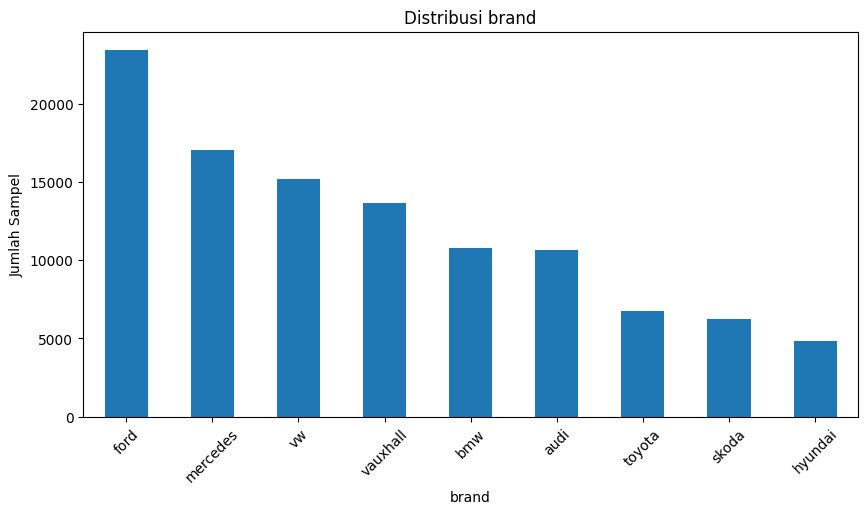


Distribusi data untuk model:
           jumlah sampel  persentase
model                              
 Focus            10042         9.3
 C Class           7646         7.0
 Fiesta            6557         6.0
 Golf              4863         4.5
 Corsa             3441         3.2
...                 ...         ...
 Accent               1         0.0
 A2                   1         0.0
 RS7                  1         0.0
 Amica                1         0.0
200                   1         0.0

[195 rows x 2 columns]


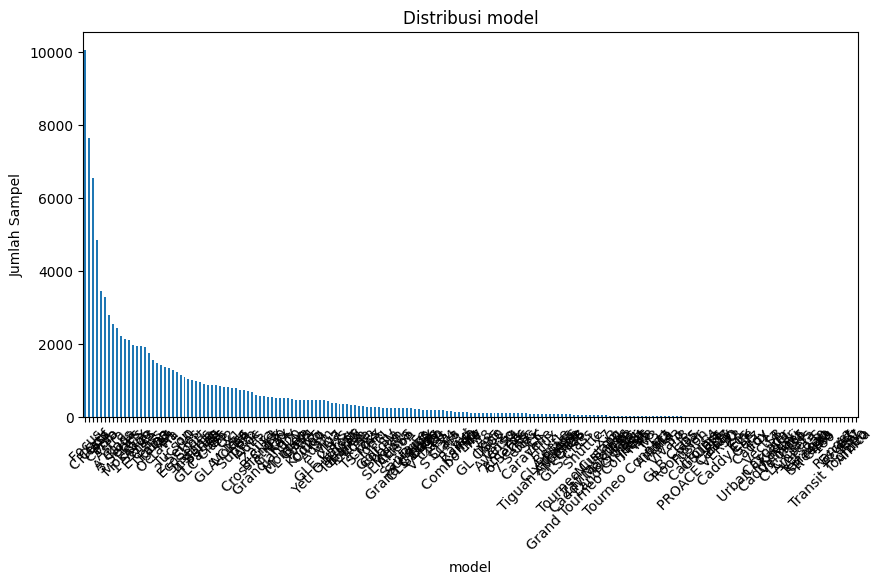


Distribusi data untuk transmission:
               jumlah sampel  persentase
transmission                           
Manual                61308        56.5
Semi-Auto             24903        22.9
Automatic             22319        20.6
Other                    10         0.0


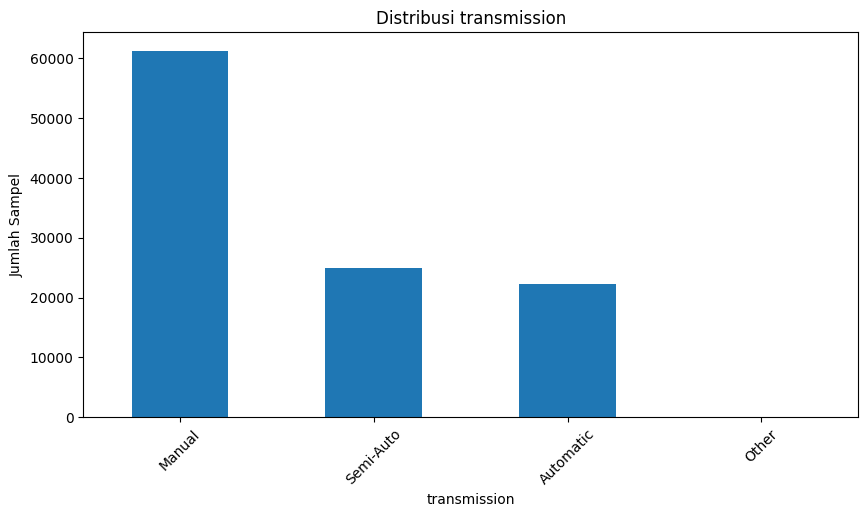


Distribusi data untuk fuelType:
           jumlah sampel  persentase
fuelType                           
Petrol            59875        55.2
Diesel            45177        41.6
Hybrid             3229         3.0
Other               253         0.2
Electric              6         0.0


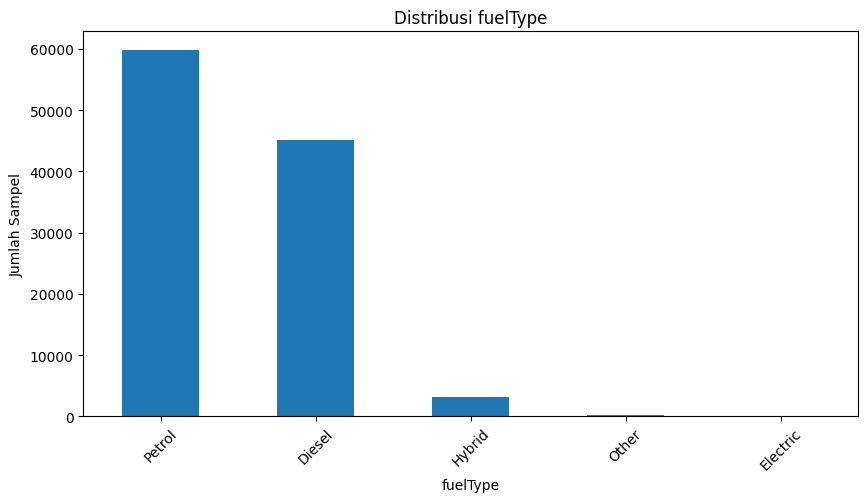

In [ ]:
for feature in categorical_features:
    count = df[feature].value_counts()
    percent = 100 * df[feature].value_counts(normalize=True)

    df_summary = pd.DataFrame({'jumlah sampel': count, 'persentase': percent.round(1)})
    print(f"\nDistribusi data untuk {feature}:\n", df_summary)

    plt.figure(figsize=(10, 5))
    count.plot(kind='bar', title=f'Distribusi {feature}')
    plt.xlabel(feature)
    plt.ylabel('Jumlah Sampel')
    plt.xticks(rotation=45)
    plt.show()

Dari viasualisasi distribusi data fitur-fitur kategorikal diatas dapat disimpulkan bahwa:
* Fitur Brand: Ford adalah merek dengan jumlah mobil terbanyak (21.6%), diikuti oleh Mercedes (15.7%) dan VW (14.0%).
* Fitur Model: Focus (9.3%) dan C Class (7.0%) adalah model mobil paling umum, tetapi ada 195 model unik, dengan beberapa hanya memiliki 1 sampel.
* Fitur Transmission: Mayoritas mobil menggunakan transmisi manual (56.5%), sedangkan Semi-Auto (22.9%) dan Automatic (20.6%) memiliki proporsi yang lebih kecil.
* Fitur Fuel Type: Bensin (55.2%) dan Diesel (41.6%) mendominasi pasar, sementara Hybrid (3.0%) dan Electric (0.0%) masih jarang ditemukan.
* Distribusi Fitur Model & Fitur Fuel Type: Banyak model dengan jumlah sampel sangat sedikit, dan kendaraan listrik hampir tidak ada dalam dataset.

### Numerical Features

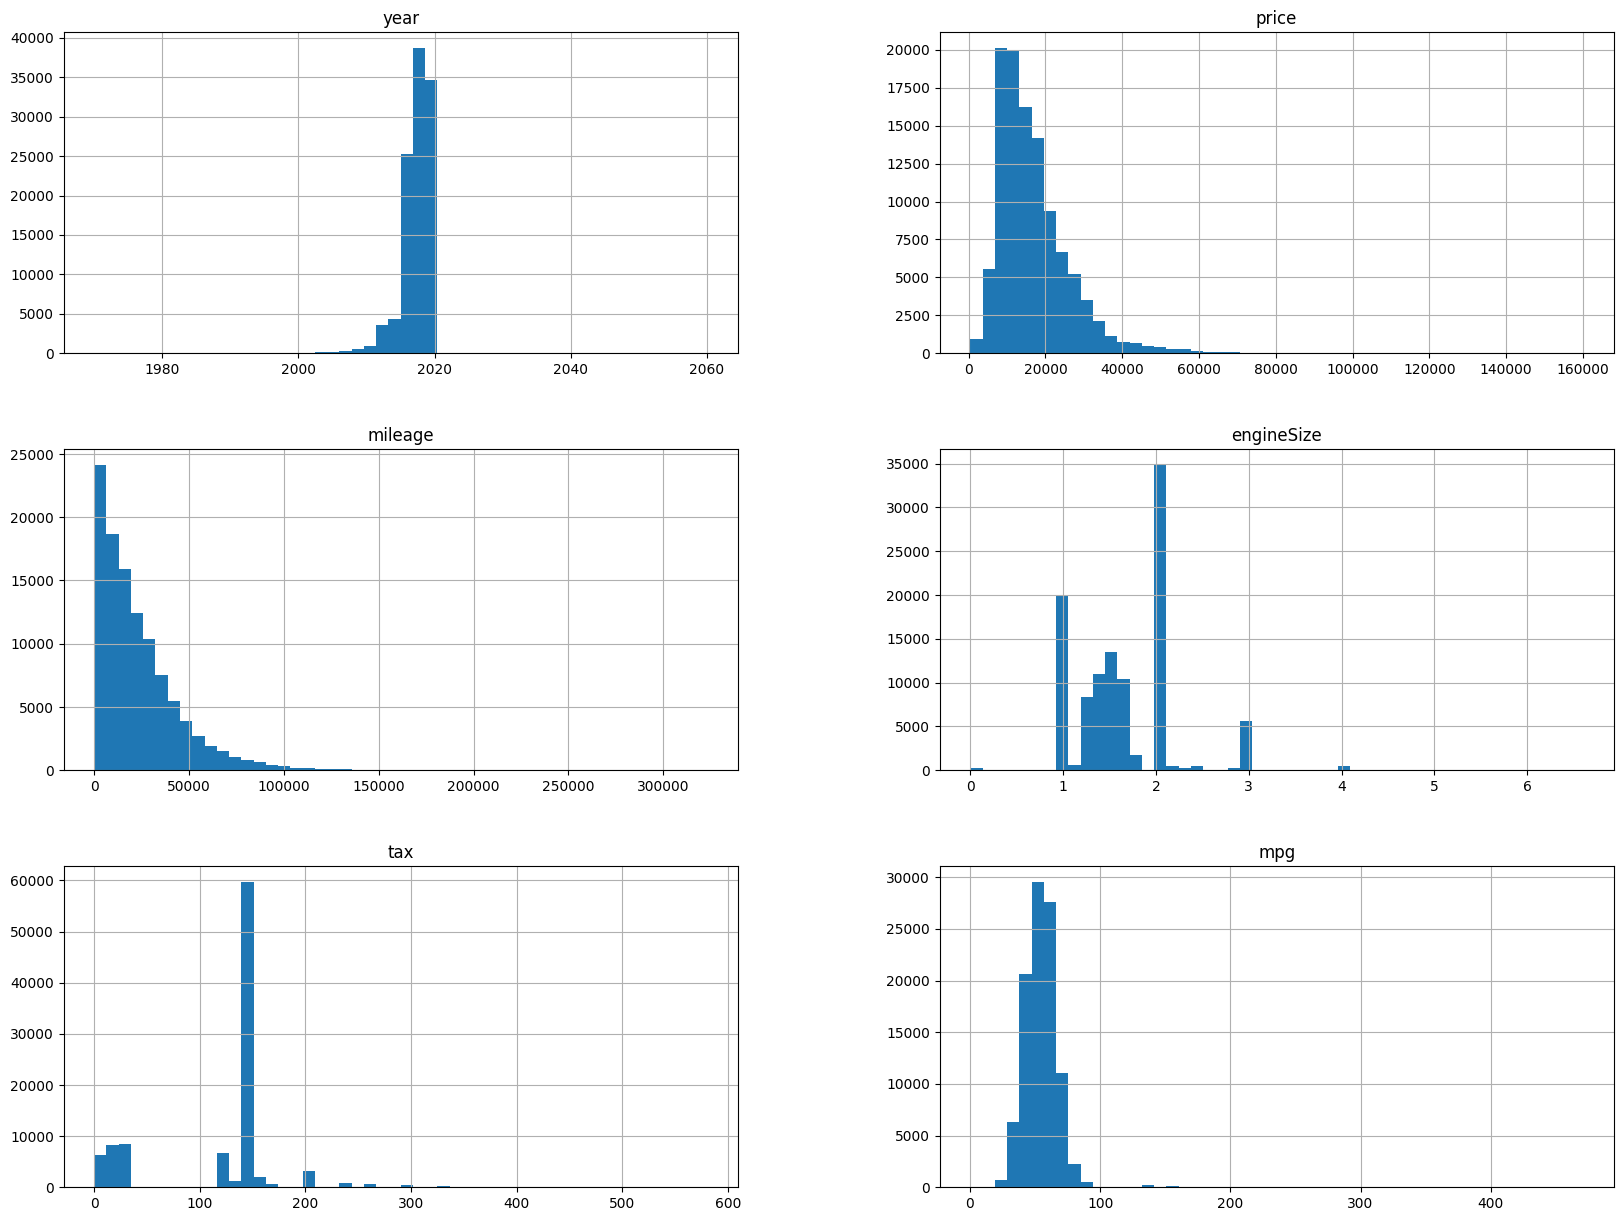

In [ ]:
df.hist(bins=50, figsize=(20,15))
plt.show()

Dari viasualisasi distribusi data fitur-fitur numerik diatas dapat disimpulkan bahwa:
* Price
  * Peningkatan harga mobil bekas sebanding dengan penurunan jumlah sampel.
  * Rentang harga mobil bekas cukup tinggi yaitu dari skala ratusan Pound Sterling (£) hingga sekitar £60.000.
  * Setengah harga berlian bernilai di bawah £20.000.
  * Distribusi harga miring ke kanan.

* Year
  * Peningkatan tahun keluaran mobil sebanding dengan peningkatan jumlah sampel.
  * Tahun keluaran mobil bekas terbaru adalah 2020.
  * Distribusi year miring ke kiri.

* Mileage (Jarak Tempuh)
  * Peningkatan jarak tempuh mobil bekas sebanding dengan penurunan jumlah sampel.
  * Distribusi mileage miring ke kanan.

* Engine Size
  * Tidak ada pola dalam distribusi.
  * Engine size dengan sampel terbanyak adalah 2.

* Tax
  * Tidak ada pola dalam distribusi.
  * Tax dengan sampel terbanyak adalah 140.

* Mpg
  * mpg memiliki distribusi yang terpusat di 50.

## Multivariate Analysis

Langkah selanjutnya adalah melakukan Multivariate Analysis. Multivariate Analysis adalah teknik analisis statistik yang digunakan untuk memahami hubungan antara dua atau lebih variabel dalam suatu dataset. Tujuan utama analisis ini adalah untuk mengidentifikasi pola, hubungan, atau korelasi antara fitur, sehingga dapat membantu dalam pemodelan prediktif dan pengambilan keputusan.

### Categorical Features

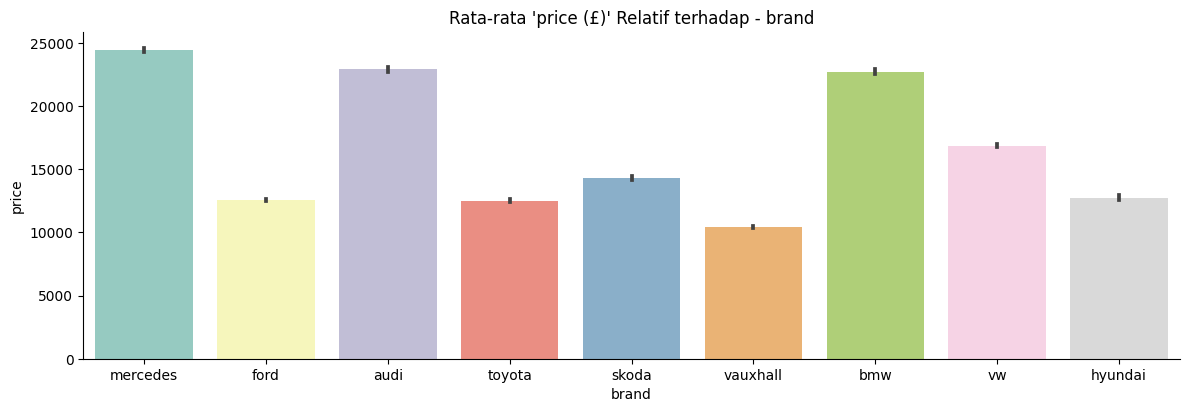

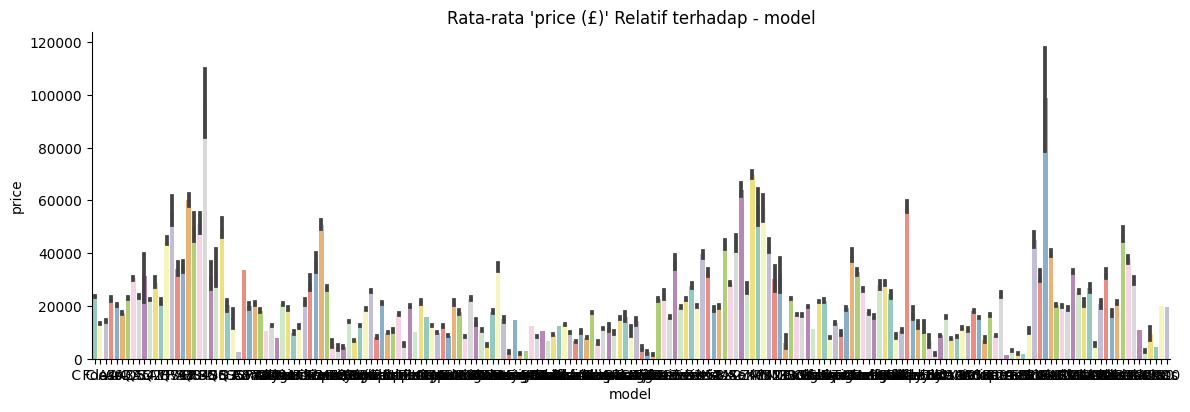

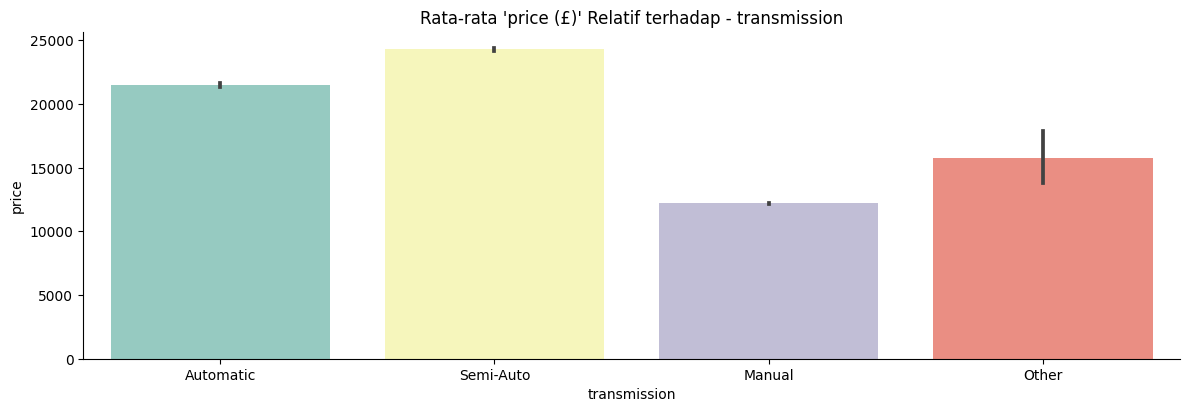

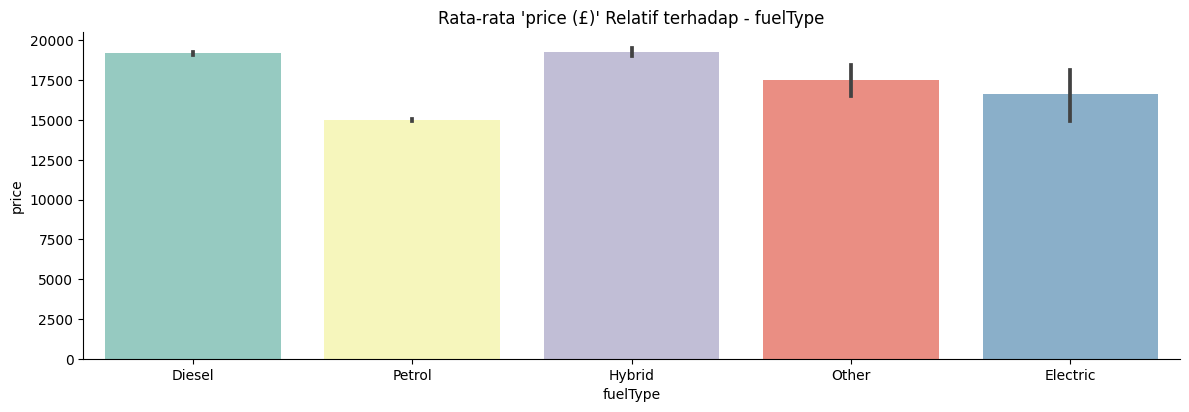

In [ ]:
cat_features = df.select_dtypes(include='object').columns.to_list()

for col in cat_features:
  sns.catplot(x=col, y="price", kind="bar", dodge=False, height = 4, aspect = 3,  data=df, palette="Set3")
  plt.title("Rata-rata 'price (£)' Relatif terhadap - {}".format(col))

Dari catplot visualisasi hubungan antara fitur price dengan fitur-fitur kategorikal diatas dapat disimpulkan bahwa:
* Pada fitur ‘Brand’, ada perbedaan rata-rata harga. 3 brand yaitu mercedes, audi, dan bmw memiliki rata-rata harga yang lebih tinggi daripada brand lainnya. Sehingga kemungkinan fitur brand memiliki pengaruh atau dampak yang cukup besar terhadap rata-rata harga.
* Pada fitur ‘Model’, ada banyak kategori dan tidak banyak perbedaan rata-rata harga. Hanya ada beberapa model yang memiliki perbedaan harga yang signifikan. Sehingga kemungkinan fitur brand memiliki pengaruh atau dampak yang cukup kecil terhadap rata-rata harga.
* Pada fitur ‘Transmission’, ada perbedaan rata-rata harga. Terutama pada semi-auto dan manual yang memiliki selisih rata-rata yang besar. Sehingga kemungkinan fitur brand memiliki pengaruh atau dampak yang cukup besar terhadap rata-rata harga.
* Pada fitur ‘Fuel Type’, ada perbedaan rata-rata harga. Terutama pada diesel dan petrol yang memiliki selisih rata-rata yang cukup besar. Sehingga kemungkinan fitur brand memiliki pengaruh atau dampak yang cukup besar meskipun tidak sebesar fitur transmission terhadap rata-rata harga.

### Numerical Features

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

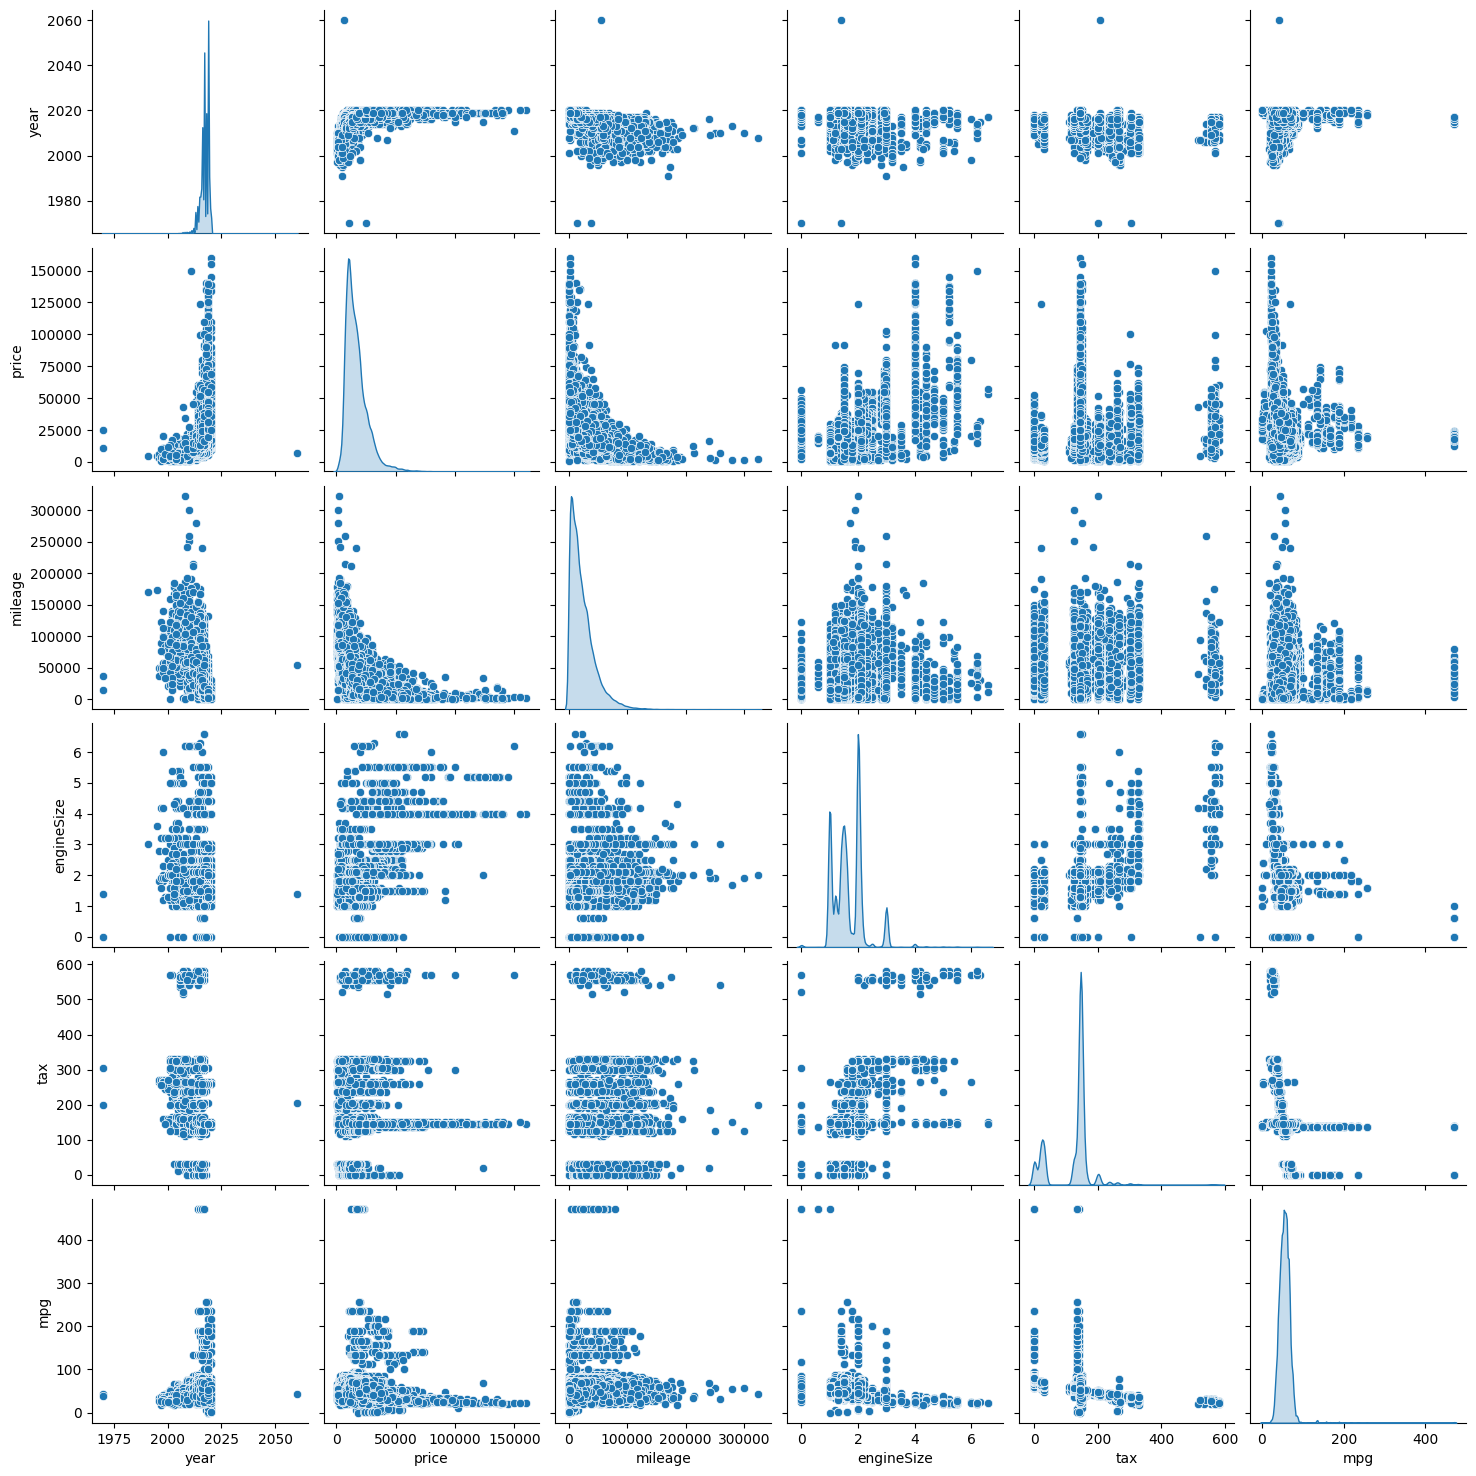

In [ ]:
sns.pairplot(df, diag_kind = 'kde')

Dari grafik pairplot diatas, jika fokus pada sumbu "price" dimana merupakan fitur target, dapat disimpulkan bahwa:

* Fitur year memiliki korelasi positif dengan fitur price.
* Fitur mileage memiliki korelasi negatif dengan fitur price.
* itur engine size, tax, dan mpg tidak memiliki korelasi yang kuat dengan fitur price karena memiliki pola yang cukup acak.

Text(0.5, 1.0, 'Correlation Matrix untuk Fitur Numerik ')

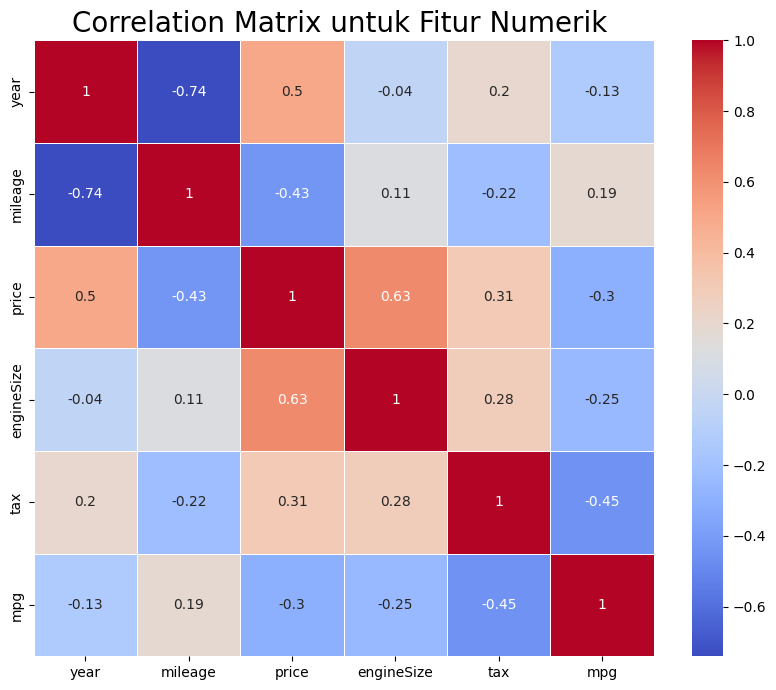

In [ ]:
plt.figure(figsize=(10, 8))
correlation_matrix = df[numerical_features].corr().round(2)

sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, )
plt.title("Correlation Matrix untuk Fitur Numerik ", size=20)

Untuk lebih jelasnya, dapat diamati grafik korelasi diatas yang menunjukkan nilai korelasi fitur price dengan fitur numerik lainnya. Dapat disimpulkan bahwa:

* fitur year, mileage, dan engine size memiliki korelasi yang cukup kuat dengan fitur price.
* fitur tax dan mpg memiliki korelasi dengan fitur price, tetapi tidak cukup kuat.

# **Data Preparation**

Setelah melakukan EDA dan sebelum membangun model machine learning, diperlukan tahapan data preparation untuk memastikan bahwa data memiliki kualitas yang baik dan dapat meningkatkan performa model. Tahapan ini mencakup pembersihan data, transformasi fitur, encoding variabel kategorikal, reduksi dimensi, serta standarisasi fitur.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108540 entries, 0 to 108539
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   brand         108540 non-null  object 
 1   model         108540 non-null  object 
 2   year          108540 non-null  int64  
 3   price         108540 non-null  int64  
 4   transmission  108540 non-null  object 
 5   mileage       108540 non-null  int64  
 6   fuelType      108540 non-null  object 
 7   engineSize    108540 non-null  float64
 8   tax           99187 non-null   float64
 9   mpg           99187 non-null   float64
dtypes: float64(3), int64(3), object(4)
memory usage: 8.3+ MB


Diatas adalah struktur dataset yang masih seperti awal. memiliki 10 fitur.

In [ ]:
df.drop(columns=["mpg", "tax"], inplace=True)
df.head()

,brand,model,year,price,transmission,mileage,fuelType,engineSize
0,mercedes,C Class,2020,30495,Automatic,1200,Diesel,2.0
1,mercedes,C Class,2020,29989,Automatic,1000,Petrol,1.5
2,mercedes,C Class,2020,37899,Automatic,500,Diesel,2.0
3,mercedes,C Class,2019,30399,Automatic,5000,Diesel,2.0
4,mercedes,C Class,2019,29899,Automatic,4500,Diesel,2.0


Lalu dilakukan proses data preparation yang pertama, yaitu Menghapus Fitur yang Memiliki Korelasi Lemah terhadap Harga.

Fitur tax dan mpg dihapus dari dataset karena memiliki korelasi yang lemah terhadap harga (price) berdasarkan analisis korelasi sebelumnya.

Alasan:
* Menghapus fitur yang tidak signifikan terhadap target variabel dapat mengurangi kompleksitas model.
* Fitur dengan korelasi lemah tidak memberikan kontribusi yang berarti dalam prediksi harga.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108540 entries, 0 to 108539
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   brand         108540 non-null  object 
 1   model         108540 non-null  object 
 2   year          108540 non-null  int64  
 3   price         108540 non-null  int64  
 4   transmission  108540 non-null  object 
 5   mileage       108540 non-null  int64  
 6   fuelType      108540 non-null  object 
 7   engineSize    108540 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 6.6+ MB


Setelah dilakukan penghapusan, diatas adalah struktur dataset yang baru dengan kolom tax dan kolom mpg yang sudah tidak ada.

In [ ]:
# Cek jumlah missing values pada dataset
df.isnull().sum()

brand           0
model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
engineSize      0
dtype: int64

Kode diatas berfungsi untuk melihat apakah ada missing values pada dataset. Setelah dijalankan ternyata hasilnya 0. Artinya sudah tidak ada missing values pada dataset.

## Menangani Missing Values & Outliers

Langkah kedua dalam data preparation adalah menangani Missing Values & Outliers.

Dari kode sebelumnya, dataset tidak memiliki missing values, sehingga tidak diperlukan imputasi.

Selanjutnya adalah mengatasi outlier. metode yang digunakan adalah metode IQR. Metode IQR (Interquartile Range) adalah teknik untuk mendeteksi dan menangani outlier dengan menganalisis sebaran data berdasarkan kuartil.

Metode IQR digunakan untuk mendeteksi dan menangani outlier dengan menganalisis rentang antara Q1 (kuartil 25%) dan Q3 (kuartil 75%). Outlier diidentifikasi jika nilainya berada di luar batas yang dihitung dengan rumus Q1 - 1.5 × IQR (batas bawah) atau Q3 + 1.5 × IQR (batas atas). Data yang berada di luar batas ini akan dihapus.

Alasan:
* Outliers dapat menyebabkan model overfitting atau memberikan prediksi yang tidak akurat.
* Metode IQR lebih robust terhadap distribusi data dibandingkan metode statistik lainnya.

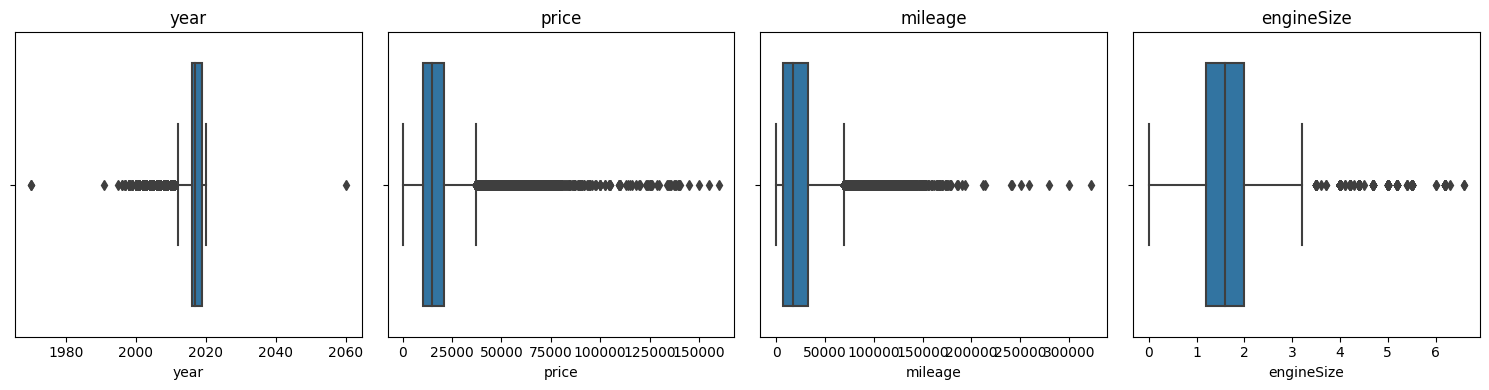

In [ ]:
# Tidak ada Missing Values, lanjut atasi Outliers
# Menampilkan boxplot dari fitur-fitur numerikal untuk mendeteksi outlier
num_features = df.select_dtypes(include=['number']).columns
num_plots = len(num_features)
rows = (num_plots // 4) + (num_plots % 4 > 0)
fig, axes = plt.subplots(nrows=rows, ncols=4, figsize=(15, 4 * rows))
axes = axes.flatten()

for i, feature in enumerate(num_features):
    sns.boxplot(x=df[feature], ax=axes[i])
    axes[i].set_title(feature)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Titik-titik diluar adalah outlier yang perlu diatasi.

In [ ]:
# Mengatasi outliers dengan metode IQR
numerical_outlier = [
    "year", "price", "mileage", "engineSize"
]

Q1 = df[numerical_outlier].quantile(0.25)
Q3 = df[numerical_outlier].quantile(0.75)
IQR = Q3 - Q1

# Menentukan batas bawah dan atas
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Menghapus outlier
df = df[~((df[numerical_outlier] < lower_bound) | (df[numerical_outlier] > upper_bound)).any(axis=1)]
df.shape

(99391, 8)

Kode diatas adalah kode untuk metode IQR mendeteksi outlier dan menghapusnya.

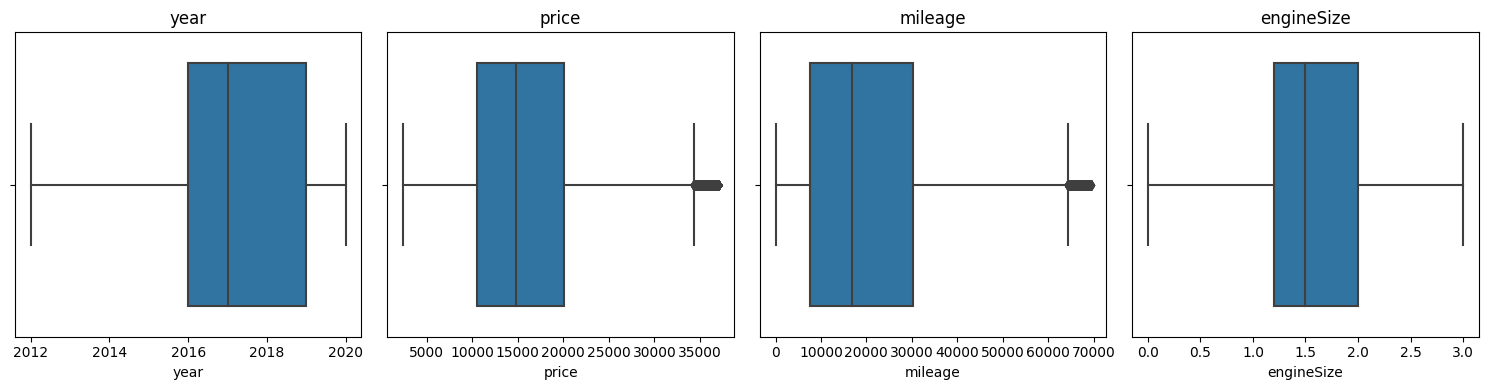

In [ ]:
# Menampilkan ulang boxplot untuk mengecek apakah outlier sudah teratasi
num_features = df.select_dtypes(include=['number']).columns
num_plots = len(num_features)
rows = (num_plots // 4) + (num_plots % 4 > 0)
fig, axes = plt.subplots(nrows=rows, ncols=4, figsize=(15, 4 * rows))
axes = axes.flatten()

for i, feature in enumerate(num_features):
    sns.boxplot(x=df[feature], ax=axes[i])
    axes[i].set_title(feature)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Setelah dilakukan metode IQR dan penghapusan outlier, terlihat persebaran data menjadi lebih baik dan tanpa outlier.

## Encoding for Categorical Feature

Langkah ketiga adalah encoding untuk fitur kategorikal.

Teknik yang digunakan: One-Hot Encoding & Frequency Encoding

Fitur brand, transmission, dan fuelType diencoding menggunakan One-Hot Encoding karena jumlah kategorinya tidak terlalu banyak. Sementara itu, fitur model diencoding menggunakan Frequency Encoding karena memiliki terlalu banyak kategori untuk One-Hot Encoding.

Alasan:
* One-Hot Encoding cocok untuk variabel dengan jumlah kategori terbatas, menghindari bias numerik.
* Frequency Encoding lebih efisien untuk variabel dengan kategori yang sangat banyak, menghindari curse of dimensionality.
* Untuk konversi data kategorikal ke data numerik agar dapat di proses model machine learning


In [ ]:
# One-Hot Encoding untuk brand, transmission, fuelType
df = pd.get_dummies(df, columns=["brand", "transmission", "fuelType"], drop_first=True)

# Frequency Encoding untuk model
model_counts = df["model"].value_counts()
df["model_encoded"] = df["model"].map(model_counts)
df = df.drop(columns=["model"])

df = df.astype(int)

df.head()

,year,price,mileage,engineSize,brand_bmw,brand_ford,brand_hyundai,brand_mercedes,brand_skoda,brand_toyota,brand_vauxhall,brand_vw,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,model_encoded
0,2020,30495,1200,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,6775
1,2020,29989,1000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,6775
3,2019,30399,5000,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,6775
4,2019,29899,4500,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,6775
5,2020,30999,1000,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,6775


## Dimensionality Reduction with PCA

Langkah keempat adalah mereduksi dimensi dengan PCA. Principal Component Analysis (PCA) adalah teknik reduksi dimensi yang digunakan untuk mengubah dataset dengan banyak fitur menjadi jumlah fitur yang lebih sedikit, sambil tetap mempertahankan informasi sebanyak mungkin. PCA bekerja dengan mengubah variabel asli menjadi sekumpulan variabel baru yang disebut principal components (komponen utama), yang saling tidak berkorelasi dan disusun berdasarkan jumlah variansi yang dijelaskan.

Fitur mileage dan year memiliki korelasi tinggi, sehingga dilakukan reduksi dimensi menggunakan PCA dengan menggabungkan kedua fitur tersebut.

Alasan:
* Mengurangi redundansi antar fitur yang memiliki hubungan kuat.
* Menghindari multikolinearitas, yang dapat menyebabkan model menjadi kurang stabil.
* Mengurangi fitur untuk meringankan komputasi tanpa menghilangkan informasi.

In [ ]:
from sklearn.decomposition import PCA


features_mileage_year = ["mileage", "year"]

pca_mileage_year = PCA(n_components=1, random_state=42)
df["vehicle_age_usage"] = pca_mileage_year.fit_transform(df[features_mileage_year]).flatten()

df.drop(columns=features_mileage_year, inplace=True)

# Menampilkan beberapa baris pertama hasil transformasi
df.head()

,price,engineSize,brand_bmw,brand_ford,brand_hyundai,brand_mercedes,brand_skoda,brand_toyota,brand_vauxhall,brand_vw,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,model_encoded,vehicle_age_usage
0,30495,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,6775,-19348.726608
1,29989,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,6775,-19548.726607
3,30399,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,6775,-15548.726541
4,29899,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,6775,-16048.726540
5,30999,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,6775,-19548.726607


In [ ]:
print(f"Variansi yang dijelaskan oleh komponen vehicle_age_usage: {pca_mileage_year.explained_variance_ratio_[0]:.2f}")

Variansi yang dijelaskan oleh komponen vehicle_age_usage: 1.00


Setelah dilakukan PCA dan dilakukan pengecekan, variansi yang dijelaskan oleh komponen baru yang dihasilkan PCA adalah 1. Artinya tidak ada informasi yang hilang dari fitur asli setelah dilakukan PCA.

## Train-Test-Split

Langkah kelima adalah melakukan Train-Test-Split atau pembagian dataset untuk training dan testing. Data dibagi menjadi 90% data training dan 10% data testing untuk memastikan model dapat dievaluasi dengan baik menggunakan data yang tidak terlihat sebelumnya.

Alasan:
* Memisahkan data untuk mengevaluasi performa model dengan data baru.
* Memastikan model tidak overfitting dengan hanya belajar dari data training.
* Data dibagi dengan perbandingan 90:10 karena dataset berukuran besar (100.000).

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["price"])
y = df["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(f"Jumlah data latih: {X_train.shape[0]}")
print(f"Jumlah data uji: {X_test.shape[0]}")

Jumlah data latih: 89451
Jumlah data uji: 9940


Jumlah data latih: 89451. Jumlah data uji: 9940.

## Standarization

Langkah keenam dan terakhir adalah melakukan Standarisasi. Standarisasi adalah proses transformasi data numerik agar memiliki skala yang seragam, biasanya dengan mean (rata-rata) = 0 dan standar deviasi = 1. Tujuannya adalah untuk memastikan bahwa setiap fitur memiliki kontribusi yang seimbang dalam model machine learning, terutama jika fitur memiliki skala atau unit yang berbeda. Teknik yang digunakan adalah Standar Scaler.

Alasan:

* Meningkatkan stabilitas dan konvergensi model berbasis gradien, seperti Gradient Boosting dan XGBoost.
* Menghindari skala yang terlalu besar pada fitur tertentu, yang dapat memengaruhi performa model.

In [ ]:
from sklearn.preprocessing import StandardScaler

numerical_features = ["engineSize", "vehicle_age_usage", "model_encoded"]

scaler = StandardScaler()

X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

X_train[numerical_features].head()

,engineSize,vehicle_age_usage,model_encoded
414,1.104940,2.050272,1.298594
63325,1.104940,-0.264713,-0.721938
37310,1.104940,0.280866,-0.282587
72452,1.104940,-1.186734,-0.728121
80127,-0.705246,1.457536,0.555580


In [ ]:
X_train[numerical_features].describe().round(4)

,engineSize,vehicle_age_usage,model_encoded
count,89451.0000,89451.0000,89451.0000
mean,0.0000,-0.0000,-0.0000
std,1.0000,1.0000,1.0000
min,-2.5154,-1.2912,-1.0283
25%,-0.7052,-0.8099,-0.7638
50%,-0.7052,-0.2331,-0.3966
75%,1.1049,0.6168,0.5556
max,2.9151,3.0692,2.2484


Setelah dilakukan standarisasi, dapat dilihat pada semua fitur numerik nilai mean (rata-rata) menjadi 0 dan standar deviasi (std) menjadi 1.

In [ ]:
df.head()

,price,engineSize,brand_bmw,brand_ford,brand_hyundai,brand_mercedes,brand_skoda,brand_toyota,brand_vauxhall,brand_vw,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,model_encoded,vehicle_age_usage
0,30495,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,6775,-19348.726608
1,29989,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,6775,-19548.726607
3,30399,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,6775,-15548.726541
4,29899,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,6775,-16048.726540
5,30999,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,6775,-19548.726607


# Modelling

Setelah melakukan Data Preparation, selanjutnya adalah melakukan modelling machine learning. Modelling pada Machine Learning adalah proses membangun dan melatih model untuk menemukan pola dalam data guna melakukan prediksi atau klasifikasi. Proses ini melibatkan pemilihan algoritma, pelatihan model dengan data, evaluasi performa, dan optimasi hyperparameter.

model atau algoritma yang digunakan adalah Random Forest, Gradient Boosting, XGBoost, KNN, dan LightGBM.

In [ ]:
!pip install xgboost lightgbm

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor

## Grid Search

Metode yang digunkan untuk pemilihan model, pelatihan model, dan optimasi hyperparameter adalah Grid Search.

GridSearch adalah metode hyperparameter tuning yang bekerja dengan mencoba semua kombinasi kemungkinan nilai hyperparameter dalam sebuah grid untuk menemukan konfigurasi terbaik. Prosesnya dimulai dengan menentukan rentang nilai hyperparameter, kemudian model dilatih menggunakan cross-validation pada setiap kombinasi. Setelah itu, setiap model dievaluasi menggunakan metrik MAE dan kombinasi hyperparameter dengan performa terbaik dipilih.

Sehingga akan didapatkan versi model terbaik dari setiap model yang digunakan.

In [ ]:
# Model yang digunakan
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, objective="reg:squarederror"),
    "KNN": KNeighborsRegressor(),
    "LightGBM": LGBMRegressor(random_state=42)
}

# Hyperparameter tuning untuk GridSearch
param_grids = {
    "Random Forest": {
        "n_estimators": [300, 500],
        "max_depth": [10, 20],
        "min_samples_split": [5, 10],
        "min_samples_leaf": [1, 2]
    },
    "Gradient Boosting": {
        "n_estimators": [100, 300, 500],
        "learning_rate": [0.01, 0.1, 0.5],
        "max_depth": [7, 15]
    },
    "XGBoost": {
        "n_estimators": [100, 300, 500],
        "max_depth": [7, 15],
        "learning_rate": [0.01, 0.1, 0.5]
    },
    "KNN": {
        "n_neighbors": [7, 10, 20],
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan"]
    },
    "LightGBM": {
        "n_estimators": [100, 300, 500],
        "learning_rate": [0.01, 0.1, 0.3],
        "num_leaves": [31, 50],
        "max_depth": [-1, 15]
    }
}

best_models = {}
grid_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    if name in param_grids:
        grid_search = GridSearchCV(model, param_grids[name], cv=3, scoring="neg_mean_absolute_error", n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_

        grid_results[name] = {
            "MAE": -grid_search.best_score_,
            "Best Params": best_params
        }

        print(f"Best Params for {name}: {best_params}")
    else:
        best_model = model.fit(X_train, y_train)

    best_models[name] = best_model

pd.set_option("display.max_colwidth", None)

grid_results_df = pd.DataFrame.from_dict(grid_results, orient="index")

# Urutkan berdasarkan MAE
grid_results_df = grid_results_df.sort_values(by="MAE", ascending=True)

print("\nBest Models from GridSearch (Sorted by MAE):")
print(grid_results_df)


Training Random Forest...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Params for Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}

Training Gradient Boosting...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Params for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500}

Training XGBoost...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Params for XGBoost: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500}

Training KNN...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Params for KNN: {'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'distance'}

Training LightGBM...
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 421
[LightGBM] [Info] Number of data points in the train set: 89451, number of used features: 16
[LightGBM] [Info] Start training from score 16066.146751
Best Params for LightGBM: {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 500, 'num_leaves': 50}

Best Models from GridSearch (Sorted by MAE):
                           MAE  \
XGBoost            1582.604978   
LightGBM           1584.173580   
Gradient Boosting  1584.469581   
Random Forest      1627.047213   
KNN                1672.468759   

                                                                                              Best Params  
XGBoost                                       {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500}  
LightGBM           

Hasil Grid Search:
* XGBoost → Model dengan MAE terendah (1582.60), menunjukkan performa baik dalam prediksi harga mobil bekas. Best Parameters: learning_rate=0.1, max_depth=7, n_estimators=500.

* LightGBM → Performa hampir setara dengan XGBoost dengan MAE 1584.17, sedikit lebih tinggi namun tetap sangat kompetitif. Best Parameters: learning_rate=0.1, max_depth=15, n_estimators=500, num_leaves=50.

* Gradient Boosting → MAE 1584.47, sangat mirip dengan LightGBM, tetapi biasanya lebih lambat dalam pelatihan dibanding LightGBM dan XGBoost. Best Parameters: learning_rate=0.1, max_depth=7, n_estimators=500.

* Random Forest → Memiliki MAE lebih tinggi (1627.05) dibanding model boosting, tetapi tetap cukup kuat dalam prediksi. Best Parameters: max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=500.

* KNN → Model dengan MAE tertinggi (1672.47), menunjukkan performa kurang optimal dibanding model lain. Best Parameters: metric='manhattan', n_neighbors=20, weights='distance'.

# Evaluation
Setelah melakukan modelling dan menemukan model-model terbaik, selanjutnya akan dilakukan proses evaluasi. Evaluasinbertujuan untuk mengukur seberapa baik model dapat memprediksi data baru. Setelah model dilatih menggunakan data train, performanya diuji menggunakan data test untuk memastikan kemampuannya dalam generalisasi terhadap data yang belum pernah dilihat sebelumnya.

Metrik evaluasi yang digunakan adalah MAE (Mean Absolute Error), MSE (Mean Squared Error), RMSE (Root Mean Squared Error), dan R² Score (Koefisien Determinasi). Selain itu, akan dilakukan percobaan prediksi untuk melihat perbandingan setiap model memprediksi harga mobil bekas secara langsung.

Random Forest Performance:
   - Train MAE: 1180.72, Test MAE: 1599.19
   - Train MSE: 2623304.47, Test MSE: 4918914.73
   - Train RMSE: 1619.66, Test RMSE: 2217.86
   - Train R² Score: 0.9479, Test R² Score: 0.9040
--------------------------------------------------
Gradient Boosting Performance:
   - Train MAE: 1382.73, Test MAE: 1571.23
   - Train MSE: 3492845.49, Test MSE: 4664656.17
   - Train RMSE: 1868.92, Test RMSE: 2159.78
   - Train R² Score: 0.9306, Test R² Score: 0.9089
--------------------------------------------------
XGBoost Performance:
   - Train MAE: 1422.86, Test MAE: 1570.31
   - Train MSE: 3757811.05, Test MSE: 4665602.29
   - Train RMSE: 1938.51, Test RMSE: 2160.00
   - Train R² Score: 0.9254, Test R² Score: 0.9089
--------------------------------------------------
KNN Performance:
   - Train MAE: 57.79, Test MAE: 1576.40
   - Train MSE: 108876.37, Test MSE: 5750268.36
   - Train RMSE: 329.96, Test RMSE: 2397.97
   - Train R² Score: 0.9978, Test R² Score: 0.8878
---

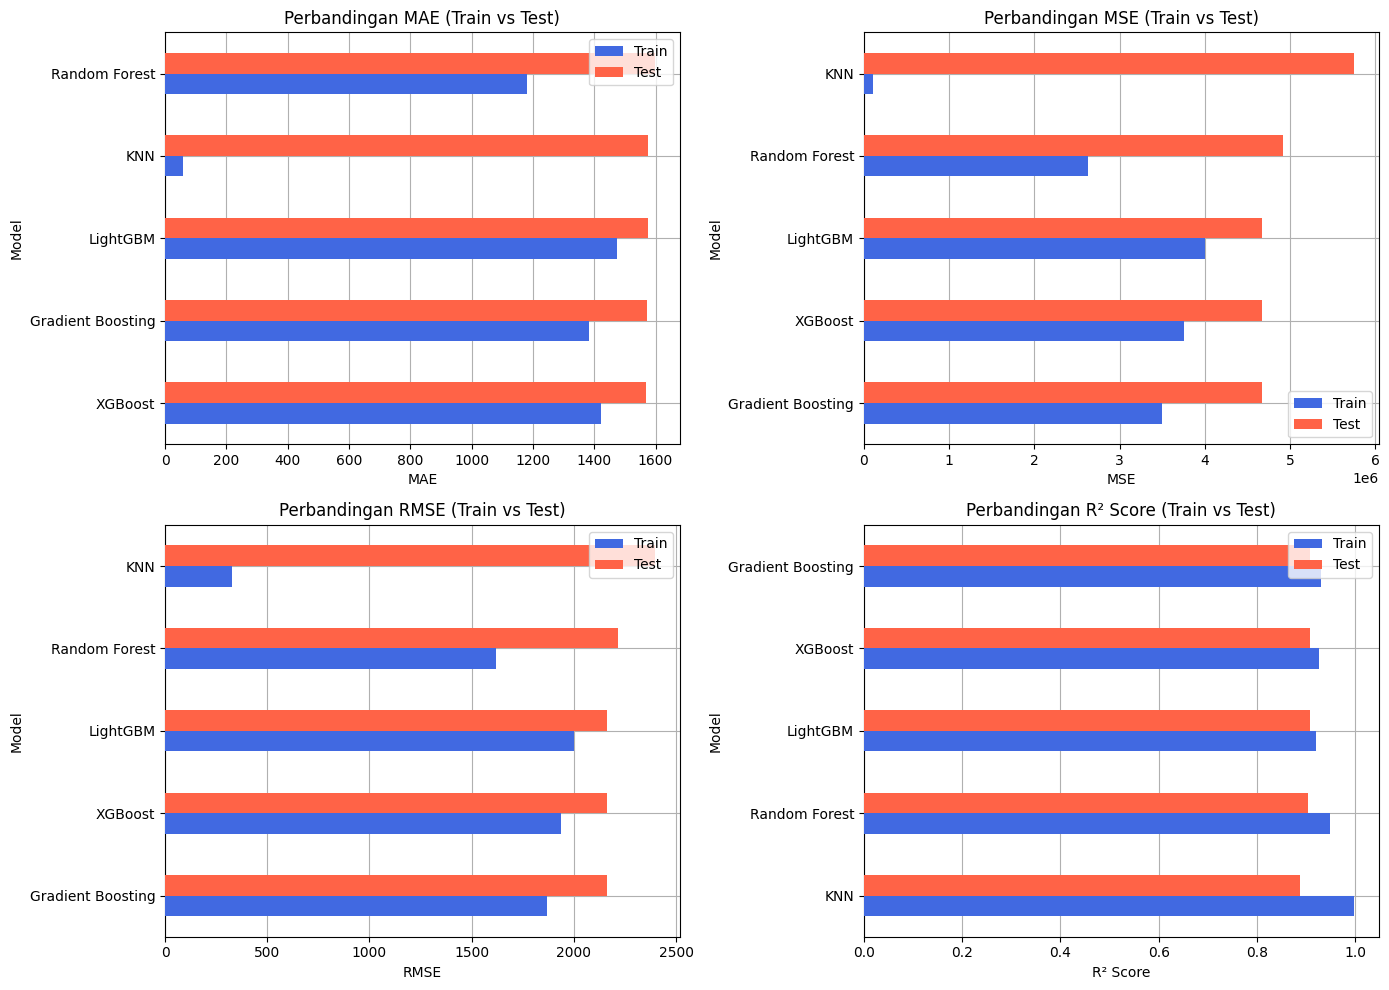

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd

results = {}

for name, model in best_models.items():
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluasi pada data train
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(y_train, y_train_pred)

    # Evaluasi pada data test
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test, y_test_pred)

    results[name] = {
        "Train MAE": train_mae, "Test MAE": test_mae,
        "Train MSE": train_mse, "Test MSE": test_mse,
        "Train RMSE": train_rmse, "Test RMSE": test_rmse,
        "Train R² Score": train_r2, "Test R² Score": test_r2
    }

    print(f"{name} Performance:")
    print(f"   - Train MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}")
    print(f"   - Train MSE: {train_mse:.2f}, Test MSE: {test_mse:.2f}")
    print(f"   - Train RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")
    print(f"   - Train R² Score: {train_r2:.4f}, Test R² Score: {test_r2:.4f}")
    print("-" * 50)

# Menampilkan hasil evaluasi dalam tabel
results_df = pd.DataFrame(results).T
print("\nFinal Model Performance:")
print(results_df)

# Visualisasi hasil evaluasi (Train vs Test)
metrics = ["MAE", "MSE", "RMSE", "R² Score"]
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for i, metric in enumerate(metrics):
    train_col = f"Train {metric}"
    test_col = f"Test {metric}"

    sorted_results = results_df[[train_col, test_col]].sort_values(by=test_col, ascending=True)

    row, col = divmod(i, 2)
    sorted_results.plot(kind="barh", ax=axes[row, col], color=["royalblue", "tomato"], zorder=3)
    axes[row, col].set_title(f"Perbandingan {metric} (Train vs Test)")
    axes[row, col].set_xlabel(metric)
    axes[row, col].set_ylabel("Model")
    axes[row, col].legend(["Train", "Test"])
    axes[row, col].grid(zorder=0)

plt.tight_layout()
plt.show()

Dari evaluasi model-model diatas, dapat disimpulkan bahwa:
* XGBoost adalah memiliki hasil MAE terendah (1570.31) dan R² tertinggi (0.9089), menunjukkan akurasi tinggi dan generalisasi yang baik. Perbedaan kecil antara Train MAE (1422.86) dan Test MAE (1570.31) menandakan model tidak mengalami overfitting maupun underfitting.
* Gradient Boosting memiliki performa hampir setara dengan XGBoost dengan MAE (1571.23) dan R² (0.9089), serta selisih Train-Test MAE yang kecil, menunjukkan model ini juga tidak mengalami overfitting atau underfitting.
* LightGBM memiliki MAE (1574.52) dan R² (0.9087), sedikit lebih tinggi dari XGBoost dan Gradient Boosting, tetapi masih dalam kisaran performa yang baik. Selisih Train-Test MAE yang kecil menandakan model tidak mengalami overfitting atau underfitting.
* Random Forest memiliki MAE lebih tinggi (1599.19) dan R² lebih rendah (0.9040), serta perbedaan Train-Test MAE cukup besar (1180.72 vs. 1599.19), menunjukkan bahwa model ini mengalami sedikit overfitting.
* KNN memiliki MAE tertinggi (1576.40) dan R² terendah (0.8878), dengan Train MAE yang sangat rendah (57.79) dibandingkan Test MAE (1576.40), menandakan overfitting ekstrem karena model hanya "menghafal" data training tetapi gagal melakukan generalisasi pada data test.

In [ ]:
# Pilih beberapa sampel untuk inference
sample_indices = np.random.choice(X_test.index, size=5, replace=False)
X_sample = X_test.loc[sample_indices].copy()
y_true = y_test.loc[sample_indices]

pred_dict = {"y_true": y_true.values}

for name, model in best_models.items():
    pred_dict[f"prediksi_{name}"] = model.predict(X_sample).round(1)

df_predictions = pd.DataFrame(pred_dict, index=sample_indices)
print(df_predictions)

       y_true  prediksi_Random Forest  prediksi_Gradient Boosting  \
2692    27099                 29282.1                     29299.4   
41327   11110                  9536.0                     10263.2   
58398    9499                 10431.9                     10633.1   
9339    11000                 10877.1                      9163.8   
68980   26995                 27175.9                     27000.0   

       prediksi_XGBoost  prediksi_KNN  prediksi_LightGBM  
2692       31850.599609       27099.0            30583.1  
41327       9965.500000        9816.6             9864.7  
58398      10426.000000       11599.4            10582.2  
9339        8947.900391       11000.0             8527.3  
68980      27356.400391       27397.9            27404.3  


Terakhir, diatas adalah hasil prediksi dari model-model terhadap harga mobil bekas dan perbandingannya dengan harga aktualnya. Dari data diatas, dapat disimpulkan bahwa:
* Pada Data 1 (y_true = 27099), KNN (27099.0) paling akurat, karena prediksinya tepat sama dengan harga asli. Random Forest (29282.1) dan Gradient Boosting (29299.4) mengalami overestimasi, tetapi masih dalam batas yang dapat diterima. LightGBM (30583.1) memiliki overestimasi yang lebih besar, sementara XGBoost (31850.6) memiliki kesalahan terbesar dengan prediksi tertinggi.

* Pada Data 2 (y_true = 11110), XGBoost (9965.5) dan LightGBM (9864.7) memiliki prediksi paling dekat, meskipun sedikit underestimasi. Gradient Boosting (10263.2) juga cukup mendekati harga asli, sedangkan KNN (9816.6) dan Random Forest (9536.0) mengalami underestimasi yang lebih besar dengan Random Forest sebagai model yang paling meleset.

* Pada Data 3 (y_true = 9499), XGBoost (10426.0) dan Random Forest (10431.9) memiliki prediksi paling akurat, dengan sedikit overestimasi. LightGBM (10582.2) dan Gradient Boosting (10633.1) juga memiliki prediksi mendekati harga asli, tetapi lebih tinggi dibandingkan XGBoost. KNN (11599.4) mengalami overestimasi terbesar, menunjukkan prediksi yang terlalu jauh dari nilai sebenarnya.

* Pada Data 4 (y_true = 11000), KNN (11000.0) paling akurat, karena prediksinya tepat sama dengan harga asli. Random Forest (10877.1) sedikit underestimasi tetapi masih mendekati nilai sebenarnya, sedangkan XGBoost (8947.9), Gradient Boosting (9163.8), dan LightGBM (8527.3) mengalami underestimasi yang cukup besar, dengan LightGBM sebagai model yang paling meleset.

* Pada Data 5 (y_true = 26995), semua model memiliki prediksi yang cukup akurat dalam rentang 27000.0 - 27404.3. Gradient Boosting (27000.0) memiliki prediksi paling mendekati harga asli, diikuti oleh Random Forest (27175.9). XGBoost (27356.4) dan KNN (27397.9) sedikit overestimasi, tetapi masih dalam rentang yang wajar, sedangkan LightGBM (27404.3) memiliki overestimasi tertinggi di antara model lainnya.

Berdasarkan evaluasi metrik (MAE, MSE, RMSE, dan R² Score) serta analisis prediksi terhadap data uji, berikut adalah urutan model dari yang terbaik hingga terburuk:


1. XGBoost - Model terbaik dengan Test MAE terendah (1570.31) dan R² tertinggi (0.9089). Memiliki performa prediksi yang stabil di sebagian besar data dan generalisasi yang baik.

2. Gradient Boosting - Sangat kompetitif dengan XGBoost, dengan Test MAE (1571.23) dan R² (0.9089) yang hampir identik. Namun, dalam beberapa kasus mengalami sedikit lebih banyak kesalahan dibanding XGBoost.

3. LightGBM - Performa mendekati XGBoost dan Gradient Boosting dengan Test MAE (1574.52) dan R² (0.9087). Meskipun masih cukup akurat, model ini terkadang mengalami underestimasi atau overestimasi yang lebih besar dibanding dua model di atas.

4. Random Forest - Memiliki Test MAE lebih tinggi (1599.19) dan R² lebih rendah (0.9040) dibanding model boosting. Model ini sering mengalami underestimasi, sehingga kurang optimal untuk prediksi harga mobil bekas.

5. KNN - Model dengan performa terburuk, memiliki Test MAE (1576.40) dan R² terendah (0.8878). Prediksi model ini sangat bervariasi—kadang sangat akurat, tetapi sering kali mengalami kesalahan yang signifikan, terutama dalam kasus overestimasi dan underestimasi ekstrem.

**Kesimpulan:**

**XGBoost adalah model terbaik untuk prediksi harga mobil bekas, diikuti oleh Gradient Boosting dan LightGBM yang masih sangat kompetitif. Random Forest dan KNN kurang direkomendasikan karena akurasinya lebih rendah dibanding model boosting.**